# Part 0: Load in libraries

In [12]:
import numpy as np
import pandas as pd
import seaborn as sbn
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import localcider
from localcider.sequenceParameters import SequenceParameters
import re
import math
import scipy
from scipy.stats import ks_2samp
from matplotlib.patches import Rectangle
import pathlib
from matplotlib import font_manager


# Setup the fonts
fonts_path = pathlib.Path.home().joinpath('fonts') # i.e. `~/fonts` (update as needed)
font_filename = 'ARIAL.TTF'
font_path = fonts_path.joinpath(font_filename)
print(font_path)

font_manager.fontManager.addfont(str(font_path))
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()
plt.rcParams['pdf.fonttype'] = 42 # Makes text editiable
plt.rcParams['ps.fonttype'] = 42

COLOR_MAP = dict()
COLOR_MAP['A']         = '#8c8c8c'
COLOR_MAP['CHNQST']    = '#077a15'
COLOR_MAP['DE']        = '#e23a36'
COLOR_MAP['FWY']       = '#f58220'
COLOR_MAP['G']         = '#86bd8d'
COLOR_MAP['ILMV']      = '#231f20'
COLOR_MAP['KR']        = '#1725c2'
COLOR_MAP['P']         = '#c25fc9'


# Using the global color map, we convert the colormap of amino acid
# groups, to a map against individual amino acids. This
# serves as our internal color map which is used for styling.
aacolor_map=dict()
for amino_acids in COLOR_MAP:
    for amino_acid in amino_acids:
        aacolor_map[amino_acid] = COLOR_MAP[amino_acids]

/home/research/kiersten.ruff/fonts/ARIAL.TTF


# Part 1: Load in Sequences and NARDINI+ analyses of location specific subsets
* Focuses on data from: 
* Scott et al. NAR 2010 (https://doi.org/10.1093/nar/gkq653)
* Greig et al. Mol Cell 2020 (10.1016/j.molcel.2020.01.025)
* Mitochondria targeting sequences from Uniprot (keyword:KW-0809) AND (taxonomy_id:9606) AND (cc_scl_term:SL-0173) with experimental evidence 
* Inspiration for how to grab mitochondria targeting sequences was from Martelli et al. Mitochondrail Medicine 2015 (doi.org/10.1007/978-1-4939-2257-4_27)

## 1.1 - Extract mitochondria targeting sequence information from UniProt

In [13]:
mtsdf=pd.read_table('data/uniprotkb_keyword_KW_0809_AND_taxonomy_2024_05_29.tsv')
# Only pick publication evidence
#Experimental evidence
#"We use the ECO code ECO:0000269 for manually curated information for which there is published experimental evidence. The PubMed identifier of the publication(s) which is the original source of the information is provided (for publications that are not in PubMed we indicate instead the corresponding UniProtKB reference number(s)).""
mtsexpdf=mtsdf[mtsdf['Transit peptide'].str.contains('ECO:0000269')==True]
print(mtsexpdf)

mtsacc=mtsexpdf['Entry'].tolist()
mtstp=mtsexpdf['Transit peptide'].tolist()
mtsfullseq=mtsexpdf['Sequence'].tolist()

mtsseq=[]
for i in range(0,len(mtstp)):
    tmp=mtstp[i].split(' ')
    tmp2=tmp[1].split('..')
    #print(tmp2)
    currst=int(tmp2[0])
    tmp3=tmp2[1].split(';')[0]
    if tmp3!='?':
        curren=int(tmp3)
        #print(currst)
        #print(curren)
        currfullseq=mtsfullseq[i]
        mtsseq.append(currfullseq[currst:curren])
        #print(mtsseq)
        print('>'+mtsacc[i]+'_'+str(currst)+'-'+str(curren)+'_'+mtsacc[i])
        print(currfullseq[currst-1:curren])
    else:
        mtsseq.append('Badseq')


          Entry  Reviewed   Entry Name  \
0        A1XBS5  reviewed  CBAR1_HUMAN   
4        A8MUP2  reviewed  CSKMT_HUMAN   
5        O00142  reviewed   KITM_HUMAN   
12       O14561  reviewed   ACPM_HUMAN   
33       O75439  reviewed   MPPB_HUMAN   
..          ...       ...          ...   
455      Q9Y255  reviewed  PRLD1_HUMAN   
473      Q9Y6E7  reviewed   SIR4_HUMAN   
482      O95178  reviewed  NDUB2_HUMAN   
534  A0A0B4J2D5  reviewed  GAL3B_HUMAN   
536      P0DPI2  reviewed  GAL3A_HUMAN   

                                         Protein names  \
0     CBY1-interacting BAR domain-containing protein 1   
4    Citrate synthase-lysine N-methyltransferase CS...   
5    Thymidine kinase 2, mitochondrial (EC 2.7.1.21...   
12   Acyl carrier protein, mitochondrial (ACP) (CI-...   
33   Mitochondrial-processing peptidase subunit bet...   
..                                                 ...   
455  PRELI domain-containing protein 1, mitochondri...   
473  NAD-dependent protein lipo

## 1.2 - Load in Scott et al. specific sequences clusters 

In [14]:
NoLSclustdf=pd.read_excel('data/Scott_NoLS_IDRs_patterning_compositional_feature_zscores_GIN_global_clusters.xlsx')
print(NoLSclustdf)

NoLSaccs=NoLSclustdf['Genes'].tolist()
NoLSclusts=NoLSclustdf['GIN Global Cluster'].tolist()
NoLSclustsgoodness=NoLSclustdf['Min Inter Clust Dist'].tolist()

    Unnamed: 0                Genes Uniprot  Start Pos  End Pos  \
0            0          BIRC5: 1-17      X0          0       17   
1            1           NOP2: 1-18      X1          0       18   
2            2         HSPA1A: 1-18      X2          0       18   
3            3  ING1b(NoLS-1): 1-17      X3          0       17   
4            4  ING1b(NoLS-2): 1-20      X4          0       20   
5            5           FGF3: 1-20      X5          0       20   
6            6           POP4: 1-23      X6          0       23   
7            7          PTHLH: 1-21      X7          0       21   
8            8           NOL4: 1-23      X8          0       23   
9            9           RPS7: 1-21      X9          0       21   
10          10          RPP38: 1-24     X11          0       24   
11          11         CDKN2A: 1-17     X12          0       17   
12          12            SSB: 1-32     X13          0       32   
13          13          PI4KA: 1-20     X16          0       2

## 1.3 - Load in Greig et al. specific sequences clusters

In [15]:
greigdf=pd.read_excel('data/Greig_MCD_IDRs_patterning_compositional_feature_zscores_GIN_global_clusters.xlsx')
print(greigdf)

greigclusts=greigdf['GIN Global Cluster'].tolist()

   Unnamed: 0             Genes Uniprot  Start Pos  End Pos  \
0           0  SNRNP70: 231-310  P08621        230      310   
1           1    CPSF6: 508-588  Q16630        507      588   
2           2    NELFE: 157-269  P18615        156      269   
3           3   FIP1L1: 446-580  Q6UN15        445      580   

                                            Sequence  GIN Global Cluster  \
0  RDRDRDRERERRERSRERDKERERRRSRSRDRRRRSRSRDKEERRR...                  26   
1  SSLQDCLHGIESKSYGSGSRRERSRERDHSRSREKSRRHKSRSRDR...                  26   
2  GAGDGPPRSFDWGYEERSGAHSSASPPRSRSRDRSHERNRDRDRDR...                  26   
3  DTSKQWDYYARREKDRDRERDRDRERDRDRDRERERTRERERERDH...                  26   

   Min Clust Dist  Min Inter Clust Dist   pol-pol  ...   M Patch   N Patch  \
0       51.349832             62.041400  0.913922  ... -0.026446 -0.076338   
1       33.717194             72.366791  0.280605  ... -0.026446 -0.076338   
2       62.770789             58.505160  2.797725  ... -0.026446 -0.0

## 1.4 - Load in mitochondria targeting sequences clusters

In [16]:
MTSclustdf=pd.read_excel('data/Uniprot_mito_transit_peptides_patterning_compositional_feature_zscores_GIN_global_clusters.xlsx')
print(MTSclustdf)

MTSaccs=MTSclustdf['Genes'].tolist()
MTSclusts=MTSclustdf['GIN Global Cluster'].tolist()
MTSclustsgoodness=MTSclustdf['Min Inter Clust Dist'].tolist()

print(MTSclusts)

    Unnamed: 0             Genes     Uniprot  Start Pos  End Pos  \
0            0      A1XBS5: 1-47      A1XBS5          0       47   
1            1      A8MUP2: 1-28      A8MUP2          0       28   
2            2      O00142: 1-33      O00142          0       33   
3            3      O14561: 1-68      O14561          0       68   
4            4      O75439: 1-43      O75439          0       43   
..         ...               ...         ...        ...      ...   
80          80      Q9UII2: 1-25      Q9UII2          0       25   
81          81      Q9Y6E7: 1-28      Q9Y6E7          0       28   
82          82      O95178: 1-33      O95178          0       33   
83          83  A0A0B4J2D5: 1-41  A0A0B4J2D5          0       41   
84          84      P0DPI2: 1-41      P0DPI2          0       41   

                                             Sequence  GIN Global Cluster  \
0     MMRRTLENRNAQTKQLQTAVSNVEKHFGELCQIFAAYVRKTARLRDK                  17   
1                        MAAL

# Part 2: Get clusters of localized IDRs

## 2.1 - Get clusters of only tested NoLS in Scott et al. 

    Unnamed: 0          Genes Uniprot  Start Pos  End Pos  \
32          32    RBBP6: 1-28     X46          0       28   
33          33   RNF213: 1-25     X47          0       25   
34          34  C1orf35: 1-30     X48          0       30   
35          35    DDX10: 1-27     X49          0       27   
36          36    SF3B2: 1-34     X50          0       34   
37          37    CEBPZ: 1-27     X51          0       27   
38          38  SMARCA2: 1-25     X52          0       25   
39          39    AP3D1: 1-31     X53          0       31   
40          40    SRP72: 1-28     X54          0       28   

                              Sequence  GIN Global Cluster  Min Clust Dist  \
32        SQDSKKKKKKKEKKKHKKHKKHKKHKKH                  23       72.966836   
33           SWTVQESKKKKRKKKKKGNKSASSE                  23       45.758551   
34      HRKSKKEKKKKKKRKHKKEKKKKDKEHRRP                  23       66.698746   
35         KKHSHRQNKKKQLRKQLKKPEWQVERE                  23       67.530755   

<AxesSubplot:>

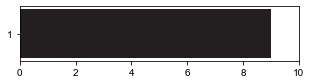

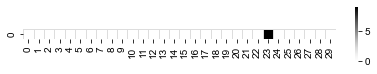

In [17]:
subgenes=['RBBP6: 1-28','RNF213: 1-25','C1orf35: 1-30','DDX10: 1-27','SF3B2: 1-34','CEBPZ: 1-27','SMARCA2: 1-25','AP3D1: 1-31','SRP72: 1-28']

subNoLSclustdf=NoLSclustdf[NoLSclustdf['Genes'].isin(subgenes)]
print(subNoLSclustdf)

subNoLSclusts=subNoLSclustdf['GIN Global Cluster'].tolist()

countclust=[]
for i in range(0,30):
    countclust.append(subNoLSclusts.count(i))

colorhex=['#d865a6','#7c2880','#e23a36','#e23a36','#e23a36','#231f20','#1f8241','#e23a36','#e23a36','#231f20','#189bd7','#1f8241','#231f20','#e23a36','#189bd7','#1f8241','#1f8241','#189bd7','#231f20','#e23a36','#8c8c8c','#7c2880','#d865a6','#231f20','#e23a36','#189bd7','#189bd7','#7c2880','#f58220','#189bd7']

plt.figure(figsize=(5,1))
currbottom=0
for i in range(0,30):
    print(currbottom)
    if i==0:
        plt.barh(1,countclust[i],color=colorhex[i])
    else:
        plt.barh(1,countclust[i],left=currbottom,color=colorhex[i])
    currbottom=currbottom+countclust[i]
    
plt.xlim([0, 10])
plt.yticks([1])

#plt.savefig('figures/2024_05/Scott_tested_NoLS_cluster_bar.pdf', transparent=False, bbox_inches = "tight")

plt.figure(figsize=(7,1))
sbn.heatmap([countclust],cmap='Greys',linewidth=1,linecolor='#dddddd',square=True)
#plt.savefig('figures/2024_05/Scott_tested_NoLS_cluster_heatmap.pdf', transparent=False, bbox_inches = "tight")

## 2.2 - Get clusters of localized IDRs from Greig et al. 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0]
4


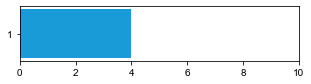

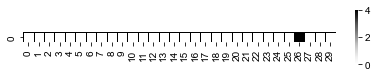

In [18]:
countclust=[]
for i in range(0,30):
    countclust.append(greigclusts.count(i))

colorhex=['#d865a6','#7c2880','#e23a36','#e23a36','#e23a36','#231f20','#1f8241','#e23a36','#e23a36','#231f20','#189bd7','#1f8241','#231f20','#e23a36','#189bd7','#1f8241','#1f8241','#189bd7','#231f20','#e23a36','#8c8c8c','#7c2880','#d865a6','#231f20','#e23a36','#189bd7','#189bd7','#7c2880','#f58220','#189bd7']

plt.figure(figsize=(5,1))
currbottom=0
for i in range(0,30):
    #print(currbottom)
    if i==0:
        plt.barh(1,countclust[i],color=colorhex[i])
    else:
        plt.barh(1,countclust[i],left=currbottom,color=colorhex[i])
    currbottom=currbottom+countclust[i]
    
plt.xlim([0, 10])
plt.yticks([1])

#plt.savefig('figures/2024_05/Scott_tested_NoLS_cluster_bar.pdf', transparent=False, bbox_inches = "tight")

plt.figure(figsize=(7,1))
sbn.heatmap([countclust],cmap='Greys',linewidth=1,linecolor='black',square=True)
#plt.savefig('figures/2024_05/Greig_speckle_MCD_cluster_heatmap.pdf', transparent=False, bbox_inches = "tight")
print(countclust)
print(sum(countclust))

## 2.3 - Get clusters of mitochondria targeting sequences

0
0
0
0
0
0
0
5
5
5
5
36
36
36
36
36
36
38
41
41
41
54
54
54
54
54
54
54
55
57
[0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 31, 0, 0, 0, 0, 0, 2, 3, 0, 0, 13, 0, 0, 0, 0, 0, 0, 1, 2, 28]
85


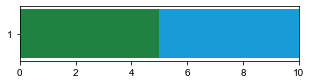

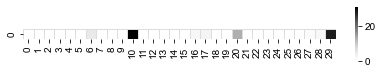

In [19]:
countclust=[]
for i in range(0,30):
    countclust.append(MTSclusts.count(i))

colorhex=['#d865a6','#7c2880','#e23a36','#e23a36','#e23a36','#231f20','#1f8241','#e23a36','#e23a36','#231f20','#189bd7','#1f8241','#231f20','#e23a36','#189bd7','#1f8241','#1f8241','#189bd7','#231f20','#e23a36','#8c8c8c','#7c2880','#d865a6','#231f20','#e23a36','#189bd7','#189bd7','#7c2880','#f58220','#189bd7']

plt.figure(figsize=(5,1))
currbottom=0
for i in range(0,30):
    print(currbottom)
    if i==0:
        plt.barh(1,countclust[i],color=colorhex[i])
    else:
        plt.barh(1,countclust[i],left=currbottom,color=colorhex[i])
    currbottom=currbottom+countclust[i]
    
plt.xlim([0, 10])
plt.yticks([1])

#plt.savefig('figures/2024_05/Scott_tested_NoLS_cluster_bar.pdf', transparent=False, bbox_inches = "tight")

plt.figure(figsize=(7,1))
sbn.heatmap([countclust],cmap='Greys',linewidth=1,linecolor='#dddddd',square=True)
#plt.savefig('figures/2024_05/MTS_cluster_heatmap.pdf', transparent=False, bbox_inches = "tight")
print(countclust)
print(sum(countclust))